# EXPLORATION 17. 문자를 읽을 수 있는 딥러닝 

## Import

In [1]:
import os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

import keras_ocr

import pytesseract
from PIL import Image
from pytesseract import Output

## Dataset

In [2]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/'

images = glob(work_dir+'*.jpeg')
images.sort()
images

['/home/aiffel0046/aiffel/ocr_python/01.jpeg',
 '/home/aiffel0046/aiffel/ocr_python/02.jpeg',
 '/home/aiffel0046/aiffel/ocr_python/03.jpeg',
 '/home/aiffel0046/aiffel/ocr_python/04.jpeg',
 '/home/aiffel0046/aiffel/ocr_python/05.jpeg',
 '/home/aiffel0046/aiffel/ocr_python/06.jpeg',
 '/home/aiffel0046/aiffel/ocr_python/07.jpeg',
 '/home/aiffel0046/aiffel/ocr_python/08.jpeg',
 '/home/aiffel0046/aiffel/ocr_python/09.jpeg',
 '/home/aiffel0046/aiffel/ocr_python/10.jpeg',
 '/home/aiffel0046/aiffel/ocr_python/11.jpeg',
 '/home/aiffel0046/aiffel/ocr_python/12.jpeg',
 '/home/aiffel0046/aiffel/ocr_python/13.jpeg',
 '/home/aiffel0046/aiffel/ocr_python/14.jpeg',
 '/home/aiffel0046/aiffel/ocr_python/15.jpeg',
 '/home/aiffel0046/aiffel/ocr_python/16.jpeg',
 '/home/aiffel0046/aiffel/ocr_python/17.jpeg',
 '/home/aiffel0046/aiffel/ocr_python/18.jpeg']

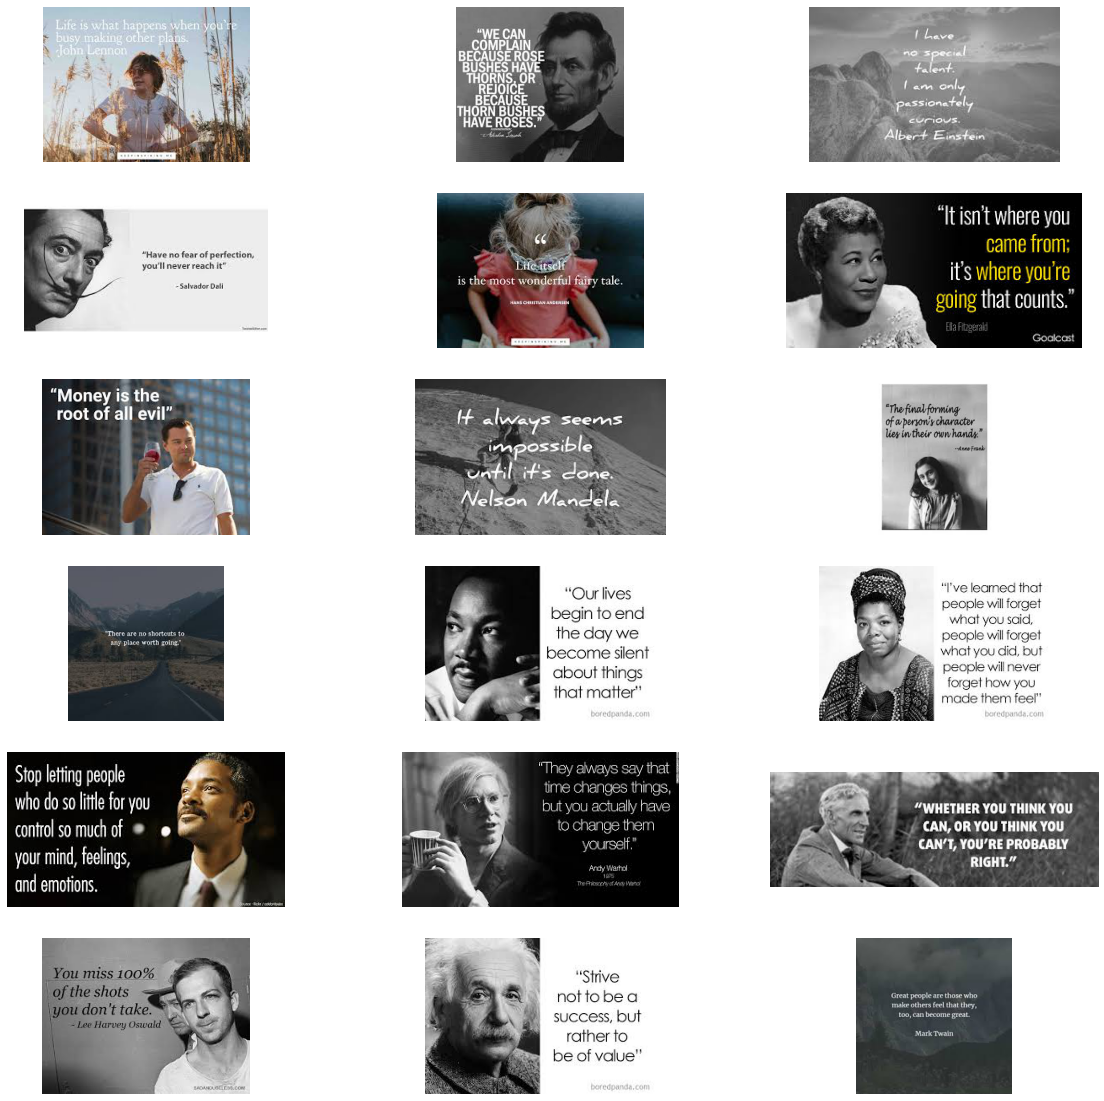

In [3]:
plt.figure(figsize=(20,20))

for idx, im in enumerate(images):
    plt.subplot(6, 3, idx+1)
    im = img.imread(im)
    plt.imshow(im)
    plt.axis('off')

## Google OCR API

In [4]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [5]:
for im in images:
    detect_text(im)

Texts:

"Life is what happens when you're
busy making other plans.
John Lennon
"

"Life"

"is"

"what"

"happens"

"when"

"you're"

"busy"

"making"

"other"

"plans."

"John"

"Lennon"
bounds: (56,45),(104,45),(104,60),(56,60)
Texts:

""WE CAN
COMPLAIN
BECAUSE ROSE
BUSHES HAVE
THORNS, OR
REJOICE
BECAUSE
THORN BUSHES
HAVE ROSES."
"

""WE"

"CAN"

"COMPLAIN"

"BECAUSE"

"ROSE"

"BUSHES"

"HAVE"

"THORNS,"

"OR"

"REJOICE"

"BECAUSE"

"THORN"

"BUSHES"

"HAVE"

"ROSES.""
bounds: (57,151),(118,151),(118,169),(57,169)
Texts:

"I have
special
talent.
no
only
passionately
am
curious.
Albert Einstein
"

"I"

"have"

"special"

"talent."

"no"

"only"

"passionately"

"am"

"curious."

"Albert"

"Einstein"
bounds: (142,140),(198,140),(198,152),(142,152)
Texts:

""Have no fear of perfection,
you'll never reach it"
- Salvador Dali
"

""Have"

"no"

"fear"

"of"

"perfection,"

"you'll"

"never"

"reach"

"it""

"-"

"Salvador"

"Dali"
bounds: (215,105),(228,105),(228,110),(215,110)
Texts:

"Lif

## keras-ocr

In [6]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/aiffel0046/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /home/aiffel0046/.keras-ocr/crnn_kurapan.h5


In [7]:
images_keras_ocr = [ keras_ocr.tools.read(im) for im in images]
prediction_groups = [pipeline.recognize([im]) for im in images]

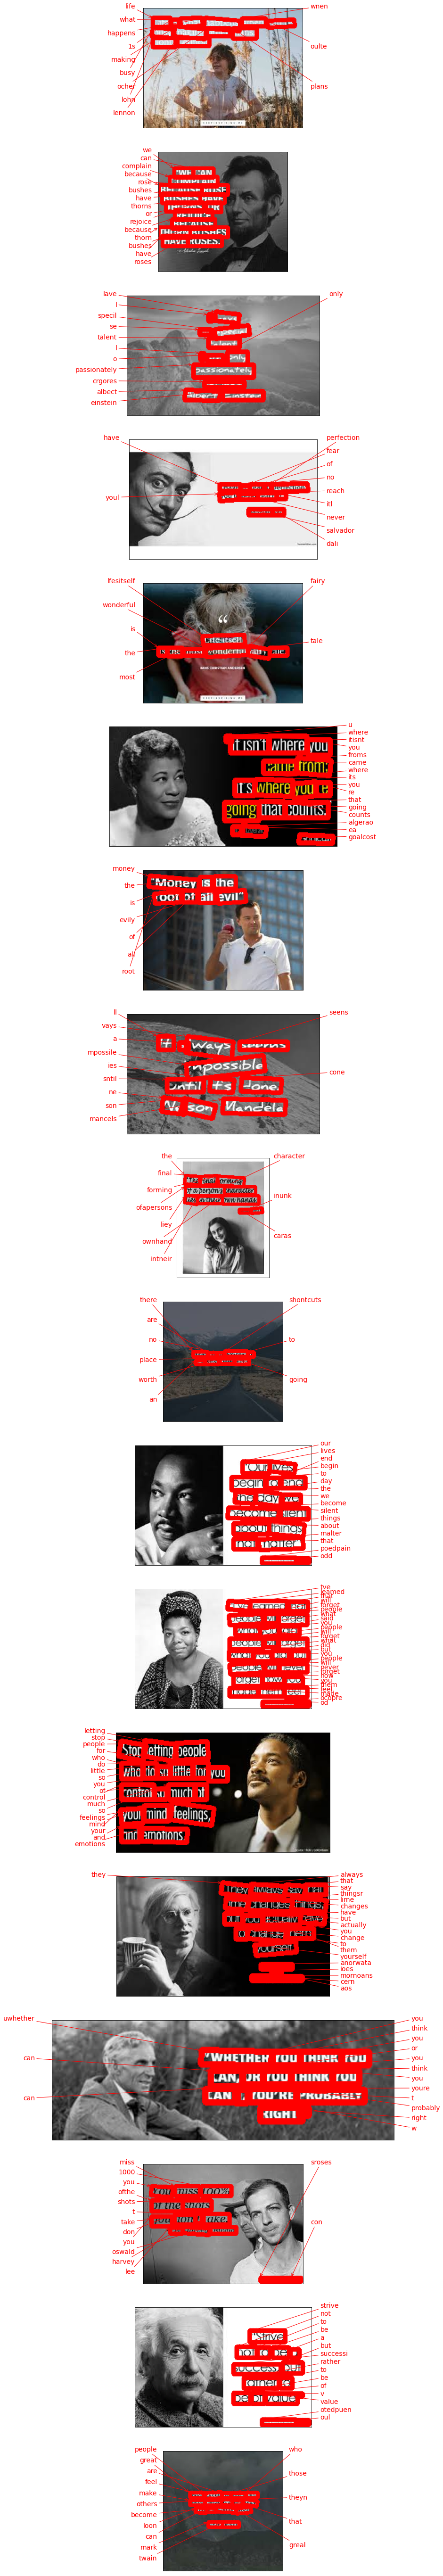

In [8]:
fig, axs = plt.subplots(nrows=len(images_keras_ocr), figsize=(100, 100))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images_keras_ocr[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

## Tesseract

In [9]:
def crop_word_regions(idx, image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
        
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [10]:
cropped_image_path_list = []
for idx, img_path in enumerate(images):
    cropped_image_path_list.append(crop_word_regions(idx, img_path, f"{work_dir}tesseract/{idx}"))

In [11]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    result = ''
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        result += " ".join(recognized_data['text'].split()) + " "
    print(result)
    print("------------------------------Done------------------------------")
    print()

In [12]:
for cr_path in cropped_image_path_list:
    recognize_images(cr_path)

 
------------------------------Done------------------------------

4      E Ri ts  - ry > _  a 
------------------------------Done------------------------------

 
------------------------------Done------------------------------

“Have ry  - fF perfection, youll Ver reach | 
------------------------------Done------------------------------

BE rie 
------------------------------Done------------------------------

IOP SEIT GR OT ES 
------------------------------Done------------------------------

“Mon ey | the gele) to ij evil = a 
------------------------------Done------------------------------

ff ee sSeernis Cay ecot a oF ts one. NP en Mencele 
------------------------------Done------------------------------

“The FU forming’ , chowactey ea Arne Fri 
------------------------------Done------------------------------

— or 
------------------------------Done------------------------------

"OW r inves pegin TO eand me aay We Hecom ea slent CDOU r TnINGS Mat matter: \\ a 
---------------

## Report

18장의 이미지에 대해서 OCR을 진행해봤습니다.  
<br>
성능을 확인해보면 다음과 같습니다.  
Google OCR API > keras-ocr >>> Tesseract  
<br>
Tesseract는 성능이 좋지 않았고, keras-ocr은 손글씨 형태의 글자에 대해서 인식률이 떨어지는 경향을 보였습니다. Google OCR API는 손글씨 형태의 글자도 잘 인식하는 것을 보였습니다.

### 손글씨 형태의 글자

(-0.5, 284.5, 176.5, -0.5)

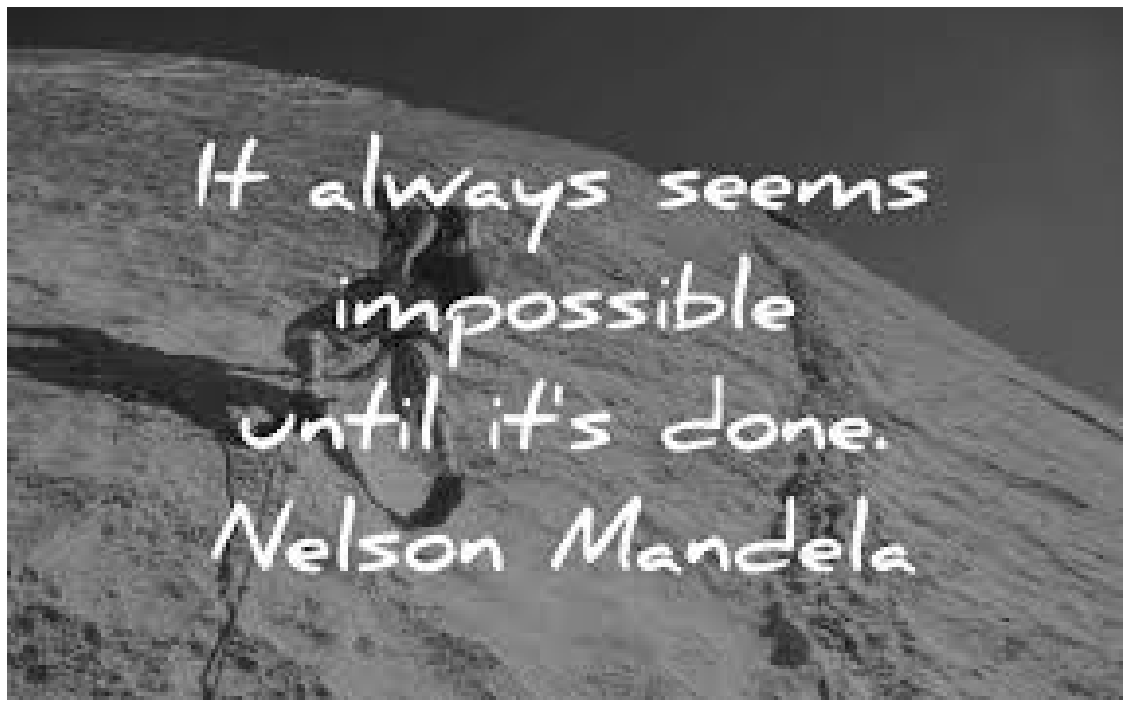

In [18]:
plt.figure(figsize=(20,20))
im = img.imread(images[7])
plt.imshow(im)
plt.axis('off')

#### Tesseract

In [21]:
recognize_images(cropped_image_path_list[7])

ff ee sSeernis Cay ecot a oF ts one. NP en Mencele 
------------------------------Done------------------------------



#### keras_ocr

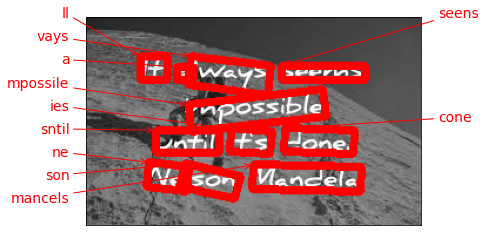

In [19]:
keras_ocr.tools.drawAnnotations(image=images_keras_ocr[7], 
                                    predictions=prediction_groups[7][0])

#### Google OCR API

In [20]:
detect_text(images[7])

Texts:

"It always seems
impossible
until it's done.
Nelson Mandela
"

"It"

"always"

"seems"

"impossible"

"until"

"it's"

"done."

"Nelson"

"Mandela"
bounds: (139,125),(231,124),(231,143),(139,144)
